In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import pandas as pd

# Load training dataset
dataset_train = pd.read_csv(r"D:\PLACEMENTS\Projects\EchoPulse\twitter_training.csv")
dataset_train.columns = ['ID', 'Topic', 'Sentiment', 'Text']

# Load testing dataset
dataset_test = pd.read_csv(r"D:\PLACEMENTS\Projects\EchoPulse\twitter_validation.csv")
dataset_test.columns = ['ID', 'Topic', 'Sentiment', 'Text']


In [9]:
dataset_train.head()

,ID,Topic,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [10]:
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def clean_text(text):
    text = str(text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = emoji.replace_emoji(text, replace='')
    text = text.lower().split()
    text = [ps.stem(word) for word in text if word not in set(all_stopwords)]
    return ' '.join(text)

corpus_train = dataset_train['Text'].apply(clean_text)
corpus_test  = dataset_test['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dixit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(corpus_train).toarray()
X_test  = cv.transform(corpus_test).toarray()


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(dataset_train['Sentiment'])
y_test  = le.transform(dataset_test['Sentiment'])


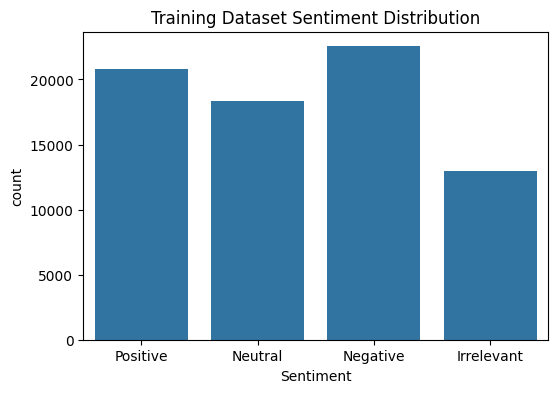

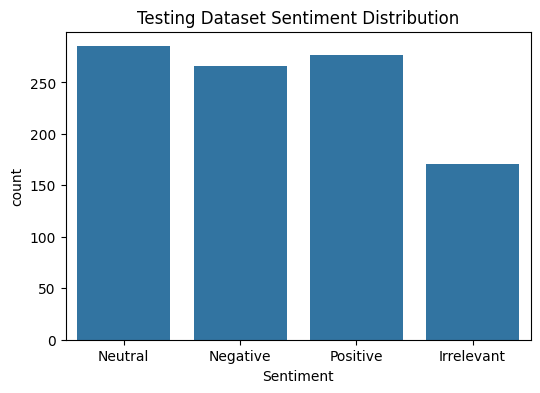

In [13]:
import seaborn as sns

# Training sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=dataset_train)
plt.title('Training Dataset Sentiment Distribution')
plt.show()

# Testing sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=dataset_test)
plt.title('Testing Dataset Sentiment Distribution')
plt.show()


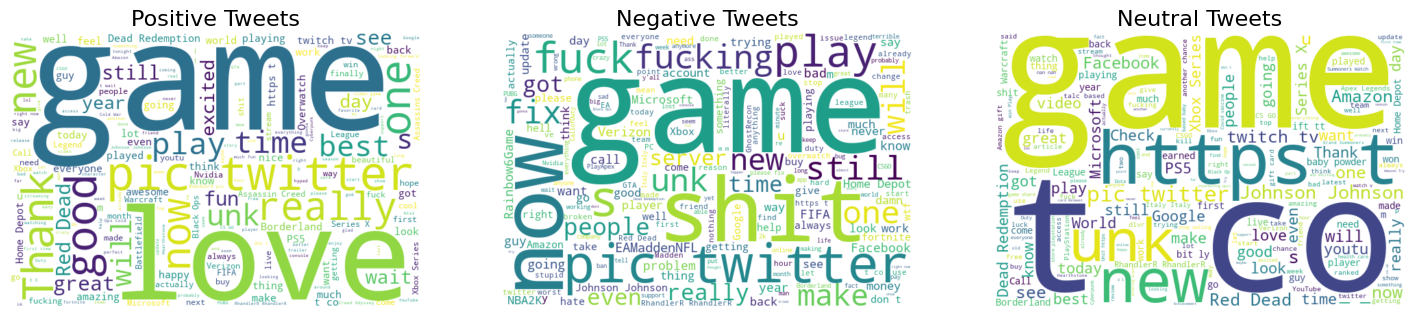

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ensure all text is string
dataset_train['Text'] = dataset_train['Text'].astype(str)

# Separate text by sentiment
positive_text = " ".join(dataset_train[dataset_train['Sentiment']=='Positive']['Text'])
negative_text = " ".join(dataset_train[dataset_train['Sentiment']=='Negative']['Text'])
neutral_text  = " ".join(dataset_train[dataset_train['Sentiment']=='Neutral']['Text'])

# Generate word clouds
wc_pos = WordCloud(width=600, height=400, background_color='white').generate(positive_text)
wc_neg = WordCloud(width=600, height=400, background_color='white').generate(negative_text)
wc_neu = WordCloud(width=600, height=400, background_color='white').generate(neutral_text)

# Plot
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Tweets', fontsize=16)
plt.subplot(1,3,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Tweets', fontsize=16)
plt.subplot(1,3,3)
plt.imshow(wc_neu, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Tweets', fontsize=16)
plt.show()


In [20]:
import lightgbm as lgb

# Train the model with early stopping
model = lgb.train(
    parameter,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# Predict on test set
y_pred = model.predict(X_test)




Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.92243


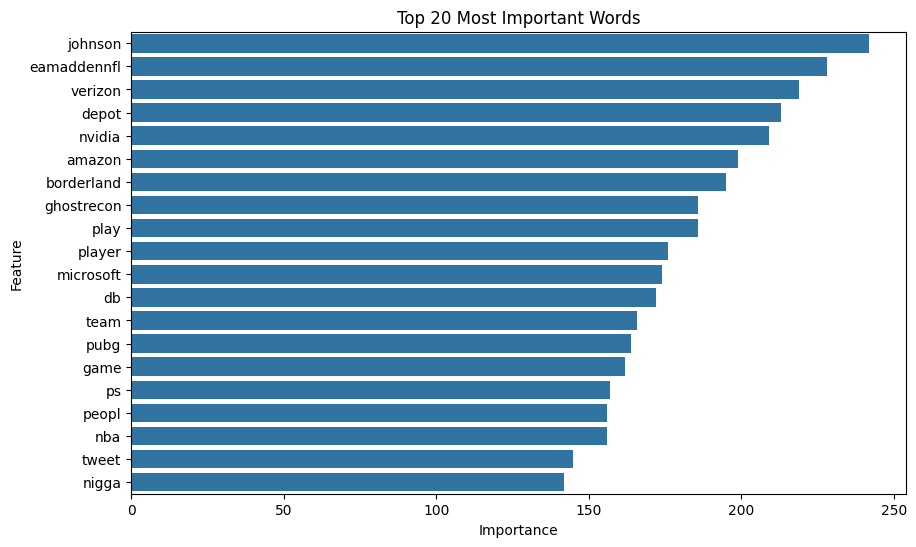

In [21]:
import pandas as pd

# Get feature importance
importance = pd.DataFrame({'Feature': cv.get_feature_names_out(), 'Importance': model.feature_importance()})
importance = importance.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Top 20 Most Important Words')
plt.show()


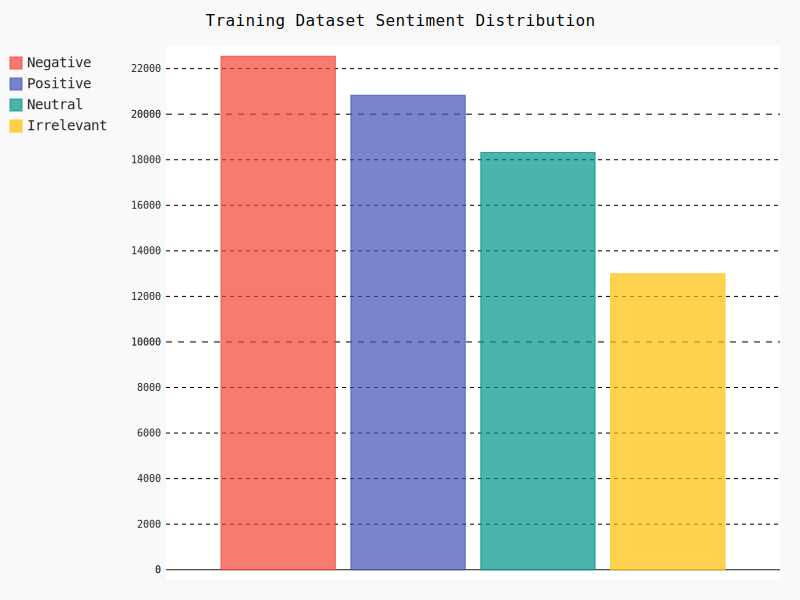

In [26]:
import pygal
from IPython.display import SVG, display

# Example: Sentiment distribution
sentiment_counts = dataset_train['Sentiment'].value_counts()

bar_chart = pygal.Bar()
bar_chart.title = 'Training Dataset Sentiment Distribution'
for sentiment, count in sentiment_counts.items():
    bar_chart.add(sentiment, count)

# Render to SVG and display
svg_data = bar_chart.render()  # renders SVG string
display(SVG(svg_data))



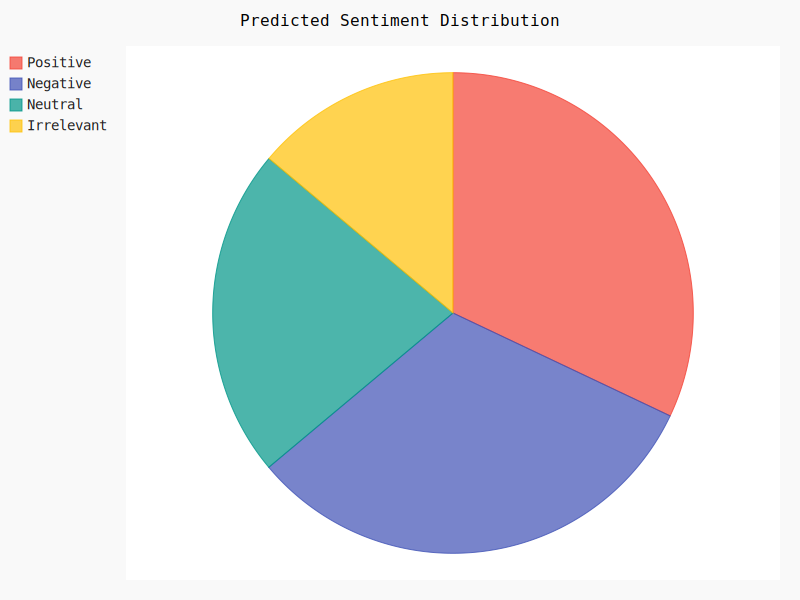

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import pygal
from IPython.display import SVG, display

# Suppose you already have cleaned text
X = corpus_train
y = dataset_train['Sentiment']  # <-- replace with your actual target column name

# Encode sentiment labels (e.g., positive, neutral, negative)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)

# Train model
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

# Get predictions
y_pred = model.predict(X_valid_tfidf)

# --- Visualization Section ---
pred_counts = pd.Series(y_pred).map({i: label for i, label in enumerate(le.classes_)}).value_counts()

pie_chart = pygal.Pie()
pie_chart.title = 'Predicted Sentiment Distribution'
for sentiment, count in pred_counts.items():
    pie_chart.add(sentiment, count)

# Render as SVG
svg_data = pie_chart.render()
display(SVG(svg_data))


In [32]:
# Convert probabilities to class labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_labels)
print(cm)

[[151  20   0   0]
 [ 55 211   0   0]
 [ 62 223   0   0]
 [ 75 202   0   0]]


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Step 1: Get predictions correctly
# If your model gives class predictions directly
y_pred_labels = model.predict(X_test)

# OR (if your model gives probabilities instead of class labels)
# Uncomment the line below instead:
# y_pred_labels = np.argmax(model.predict_proba(X_test), axis=1)

# ✅ Step 2: Evaluate performance
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_test, y_pred_labels, zero_division=0))



Confusion Matrix:
 [[ 32  38  62  39]
 [ 48  99  79  40]
 [ 62  68 103  52]
 [ 46  76  96  59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.19      0.18       171
           1       0.35      0.37      0.36       266
           2       0.30      0.36      0.33       285
           3       0.31      0.21      0.25       277

    accuracy                           0.29       999
   macro avg       0.28      0.28      0.28       999
weighted avg       0.30      0.29      0.29       999



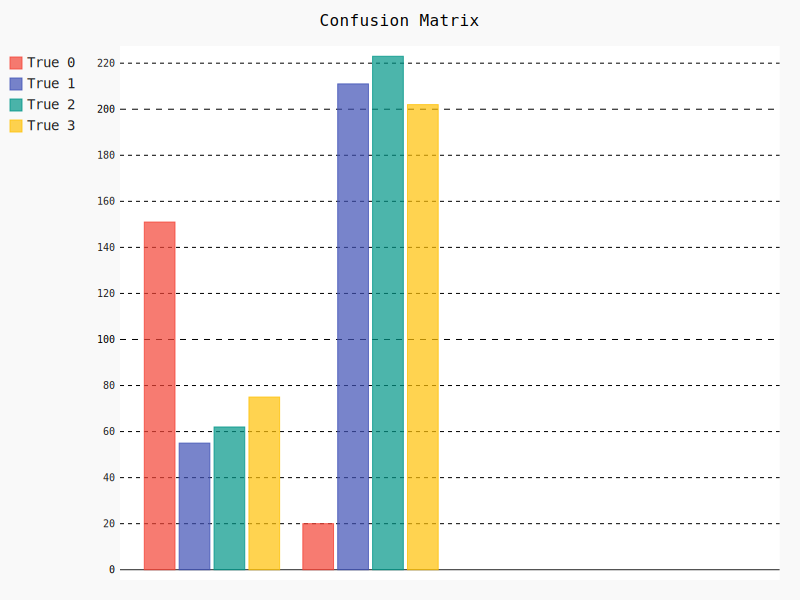

In [34]:
import pygal
from IPython.display import SVG, display

cm_chart = pygal.Bar()
cm_chart.title = 'Confusion Matrix'

# Add rows as lists
for i, row in enumerate(cm):
    cm_chart.add(f'True {i}', row.tolist())

display(SVG(cm_chart.render()))
